# **Lab 7.2 CNN**

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset, random_split
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

Complete the `load_data()` function that loads the image using `ImageFolder()` with the specific `transforms.compose()` provided below.
`load_data()` will return `DataLoader()` and print the information about the Dataset.
This function must load only a pair of classes from the entire dataset.
Please ensure that the final image is in grayscale and has a size of 28x28.

`transforms.Compose()` :
- `transforms.Resize()`
- `transforms.ToTensor()`
- `transforms.Pad()`
- `transforms.RandomRotation(),`
- `transforms.CenterCrop()`

Resource : [`transforms.Compose()`](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html#compose), [`torchvision.transforms v1`](<https://pytorch.org/vision/stable/transforms.html#v1-api-reference:~:text=custom)%20tv_tensor%20type.-,V1%20API%20Reference,-Geometry>)

In [33]:

def load_data(path, class_names):
	### START CODE HERE ###
	# Apply the transformations
	transform = transforms.Compose([
        transforms.Resize((32, 32)),                 # Resize to 32x32
        transforms.ToTensor(),                       # Convert to tensor
        transforms.Pad(32,fill=1),                           # Add padding of 2 pixels on all sides
        transforms.RandomRotation(30),               # Randomly rotate images by up to 10 degrees
        transforms.CenterCrop(32),                   # Crop to 28x28
        transforms.Grayscale(num_output_channels=1)            # Convert the image to a tensor
	])

	dataset = ImageFolder(root=path, transform=transform)

	indices = [i for i, (_, label) in enumerate(dataset) if dataset.classes[label] in class_names]
	subset = Subset(dataset, indices)
	train_size = int(0.8 * len(subset))
	test_size = len(subset) - train_size
	train_dataset, test_dataset = random_split(subset, [train_size, test_size])
	train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
	test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
	def count_classes(dataset):
		class_counts = Counter()
		for _, label in dataset:
			class_counts[label] += 1
		return class_counts

	train_class_counts = count_classes(train_dataset)
	test_class_counts = count_classes(test_dataset)
	print("Train Dataset:")
	for cls, count in train_class_counts.items():
		print(f"Number of images in class {cls}: {count}")
	print(f"Number of training samples: {len(train_dataset)}")

	print("\nTest Dataset:")
	for cls, count in test_class_counts.items():
		print(f"Number of images in class {cls}: {count}")
	print(f"Number of testing samples: {len(test_dataset)}")

	### END CODE HERE ###
	
	return train_loader, test_loader

Use your `load_data()` function to load the dataset in the cell below. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
📃Train Dataset:
	Number of images in class 0: 313
	Number of images in class 1: 308
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 75
	Number of images in class 1: 81
	Number of testing samples: 156
```


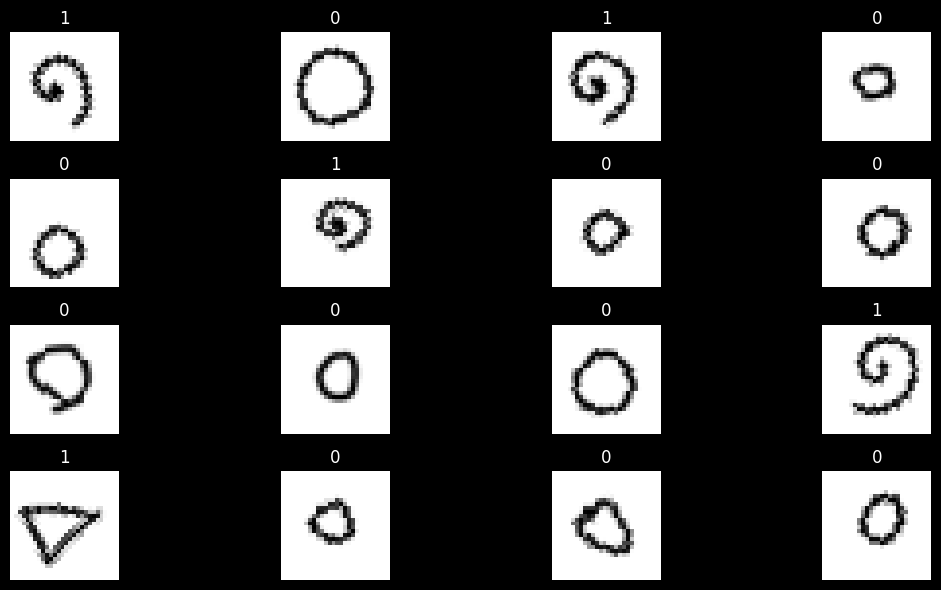

</details>

Train Dataset:
Number of images in class 0: 309
Number of images in class 5: 318
Number of images in class 3: 302
Number of images in class 9: 299
Number of images in class 8: 322
Number of images in class 2: 310
Number of images in class 6: 305
Number of images in class 1: 322
Number of images in class 7: 313
Number of images in class 4: 305
Number of training samples: 3105

Test Dataset:
Number of images in class 4: 83
Number of images in class 2: 79
Number of images in class 8: 66
Number of images in class 3: 86
Number of images in class 1: 67
Number of images in class 5: 70
Number of images in class 9: 89
Number of images in class 0: 79
Number of images in class 6: 83
Number of images in class 7: 75
Number of testing samples: 777


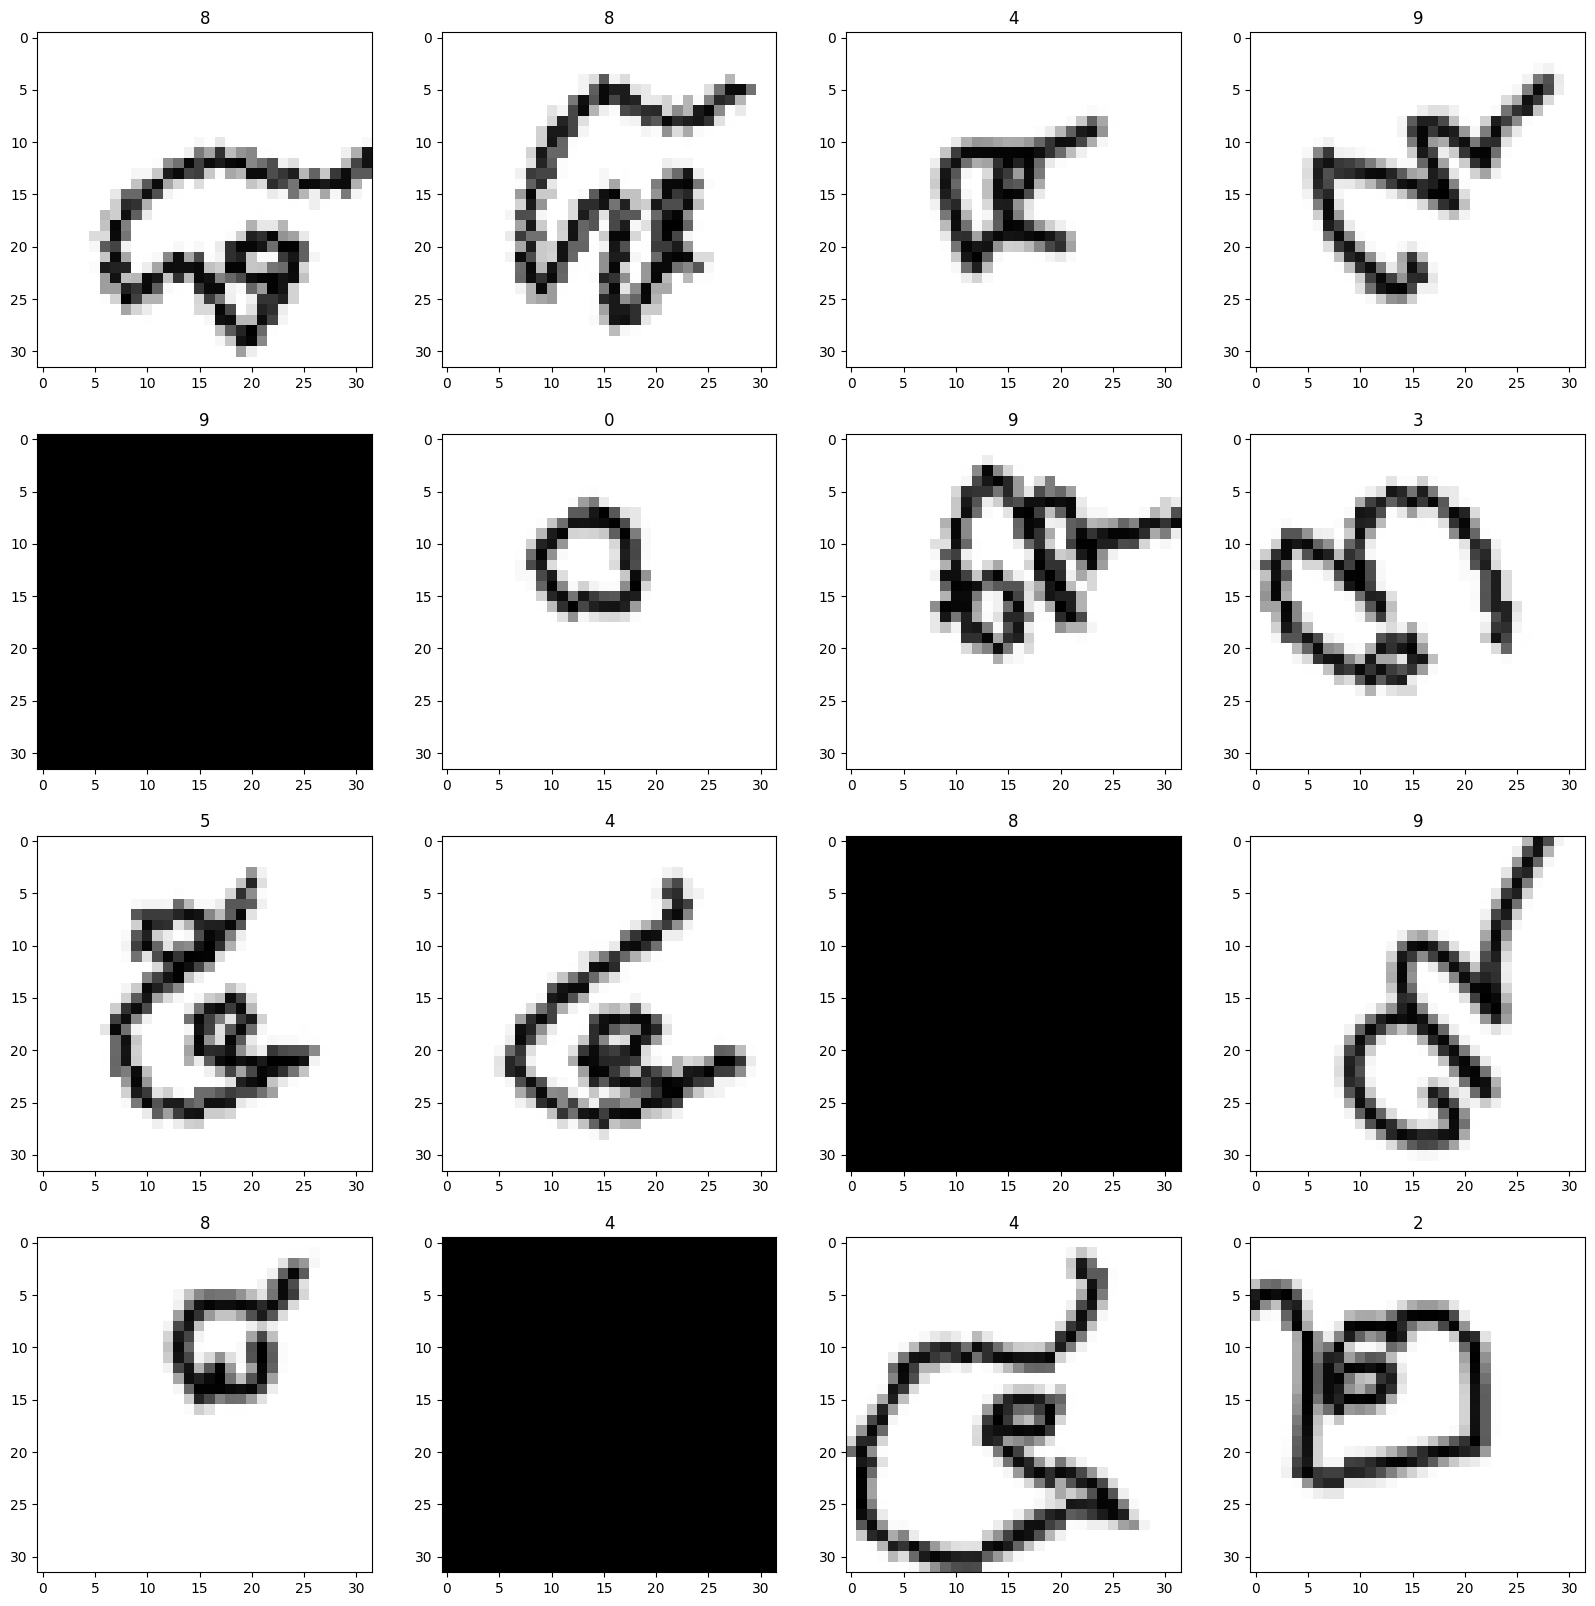

In [34]:
### START CODE HERE ###
class_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
train_loader, test_loader = load_data("/home/tkrittithee/mai_workspace/repo/Lab7_Data-Augmentation-CNN/thai-handwriting-number.appspot.com/", class_names)

fig = plt.figure(figsize=(20, 20))
train_features, train_labels = next(iter(train_loader))

axs = fig.subplots(4, 4)
i = 0
for img in train_features:
	row_index = i // 4
	column_index = i % 4
	img = np.transpose(img, (1, 2, 0))
	axs[row_index][column_index].set_title(str(train_labels[i].tolist()))
	axs[row_index][column_index].imshow(img, cmap="gray")
	i += 1


### END CODE HERE ###

### **Create Models**
**CustomLeNet**:
- **Input**:  RGB images
- **Architecture**: Multiple convolutional layers with ReLU activations, followed by fully connected layers with ReLU activations
- **Description**: This is a convolutional neural network with two convolutional layers followed by two fully connected layers. It applies convolutional operations with ReLU activations, followed by flattening the output and passing through fully connected layers with ReLU activations. Finally, it produces a 10 neurons output.


In [35]:
### START CODE HERE ###
class CustomLeNet(nn.Module):
    def __init__(self):
        super(CustomLeNet, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)  
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  

    def forward(self, x):
        # Convolutional layer 1
        x = F.relu(self.conv1(x))
        x = F.avg_pool2d(x, kernel_size=2, stride=2)  

        # Convolutional layer 2
        x = F.relu(self.conv2(x))
        x = F.avg_pool2d(x, kernel_size=2, stride=2)  
        
        # Flatten the output
        x = x.view(x.size(0), -1) 
        # print(x.shape)
        
        # Fully connected layer 1
        x = F.relu(self.fc1(x))
        
        # Fully connected layer 2
        x = F.relu(self.fc2(x))
        
        # Output layer with sigmoid (0-1)
        x = torch.sigmoid(self.fc3(x))  
        
        return x
### END CODE HERE ###



Complete the `train()` function in the cell below. This function should evaluate the model at every epoch, log the training loss/accuracy, test loss/accuracy. Additionally, it should save the model at the last epoch.

Resource : [PyTorch Training loop](<https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#:~:text=%3D0.9)-,The%20Training%20Loop,-Below%2C%20we%20have>)


In [36]:

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
def train(model, opt, loss_fn, train_loader, test_loader, epochs=10, checkpoint_path=None, device='cpu', log_path="training_log.txt"):
	### START CODE HERE ###

    model.to(device)

    with open(log_path, 'w') as log_file:

        for epoch in range(epochs):
            # save ค่าแต่ละ epoch และทำให้อยู่ใน mode train
            model.train()  
            train_loss = 0.0
            sum_acc_train = 0

            # Training loop (data -> (image, labels))
            # move (image and labels) to device
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                # Zero the gradients (set zero (weight, bias))
                opt.zero_grad()

                # Forward pass 
                outputs = model(images)
                loss = loss_fn(outputs, labels)  # Use raw labels, no need for one-hot encoding if using CrossEntropyLoss

                # Backward pass and optimization
                # นำ loss ที่ได้มาคำนวน best gradients (weight, bias)
                # อัพเดต parameter
                loss.backward()
                opt.step()

                # Log training statistics
                train_loss += loss.item()

                # Get the predictions by taking the index with the maximum value
                _, predicted = torch.max(outputs, dim=1)

                # Calculate correct predictions
                correct = (predicted == labels).sum().item()  # Compare with raw labels, no need to reshape
                sum_acc_train += correct  # Count correct predictions

            # Evaluation loop
            model.eval()  # Set model to evaluation mode
            test_loss = 0.0
            sum_acc_test = 0
            all_test_preds = []
            all_test_labels = []

            with torch.no_grad():  # Disable gradient calculation
                for images, labels in test_loader:
                    images, labels = images.to(device), labels.to(device)

                    # Forward pass 
                    outputs = model(images)
                    loss = loss_fn(outputs, labels)  # Use raw labels

                    test_loss += loss.item()

                    _, predicted = torch.max(outputs, dim=1)

                    correct = (predicted == labels).sum().item()  # Compare directly with raw labels
                    sum_acc_test += correct  # Count correct predictions

                    all_test_preds.extend(predicted.cpu().numpy())
                    all_test_labels.extend(labels.cpu().numpy())

            # Generate confusion matrix for test
            test_cm = confusion_matrix(all_test_labels, all_test_preds, normalize="true")
            precision, recall, f1_score, _ = precision_recall_fscore_support(all_test_labels, all_test_preds, average=None)

            # Log results 
            avg_train_loss = train_loss / len(train_loader)
            avg_test_loss = test_loss / len(test_loader)
            accuracy_train = sum_acc_train / len(train_loader.dataset)  # Correct accuracy calculation
            accuracy_test = sum_acc_test / len(test_loader.dataset)    # Correct accuracy calculation

            log_file.write(f"Epoch [{epoch + 1}/{epochs}]\n")
            log_file.write(f"Training accuracy : {accuracy_train:.4f} | Training loss : {avg_train_loss:.4f}\n")
            log_file.write(f"Test accuracy     : {accuracy_test:.4f} | Testing loss : {avg_test_loss:.4f}\n")
            # log_file.write(f"Confusion Matrix for Epoch [{epoch + 1}/{epochs}] (Test):\n{test_cm}\n")
            for i in range(len(precision)):
                log_file.write(f"Precison : class {i}  {precision[i]:.4f} | Recall   : class {i}  {recall[i]:.4f} | F1-score : class {i}  {f1_score[i]:.4f}\n")
            log_file.write("-"*50 + "\n")

            print(f"Epoch [{epoch + 1}/{epochs}]")
            print(f"Training accuracy : {accuracy_train:.4f} | Training loss : {avg_train_loss:.4f}")
            print(f"Test Accuracy     : {accuracy_test:.4f} | Testing loss  : {avg_test_loss:.4f}")
            # print(f"Confusion Matrix for Epoch [{epoch + 1}/{epochs}] (Test):\n", test_cm)
            for i in range(len(precision)):
                print(f"Precison : class {i}  {precision[i]:.4f} | Recall   : class {i}  {recall[i]:.4f} | F1-score : class {i}  {f1_score[i]:.4f}\n")
            print("-"*50)

        # Save the model at the last epoch
        if checkpoint_path:
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Model saved to {checkpoint_path}')

	### END CODE HERE ###

Use your `train()` function to train models.

In [37]:
### START CODE HERE ###
import torch.optim as optim

# Initialize model, optimizer, and loss function
model = CustomLeNet()
opt = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
loss_fn = nn.CrossEntropyLoss()  # Binary Cross Entropy loss for binary classification

# Define your DataLoader (assuming train_loader and test_loader are already defined)

# Train the model
train(model, opt, loss_fn, train_loader, test_loader, epochs=10, checkpoint_path='/home/tkrittithee/mai_workspace/repo/Lab7_Data-Augmentation-CNN/check/hello', device='cuda' if torch.cuda.is_available() else 'cpu')
### END CODE HERE ###

Epoch [1/10]
Training accuracy : 0.1823 | Training loss : 2.2264
Test Accuracy     : 0.2831 | Testing loss  : 2.0631
Precison : class 0  0.8000 | Recall   : class 0  0.0506 | F1-score : class 0  0.0952

Precison : class 1  0.0000 | Recall   : class 1  0.0000 | F1-score : class 1  0.0000

Precison : class 2  0.2611 | Recall   : class 2  0.6709 | F1-score : class 2  0.3759

Precison : class 3  0.6154 | Recall   : class 3  0.0930 | F1-score : class 3  0.1616

Precison : class 4  0.2653 | Recall   : class 4  0.3133 | F1-score : class 4  0.2873

Precison : class 5  0.2062 | Recall   : class 5  0.2857 | F1-score : class 5  0.2395

Precison : class 6  0.3271 | Recall   : class 6  0.4217 | F1-score : class 6  0.3684

Precison : class 7  0.2722 | Recall   : class 7  0.6533 | F1-score : class 7  0.3843

Precison : class 8  0.2500 | Recall   : class 8  0.1667 | F1-score : class 8  0.2000

Precison : class 9  0.5600 | Recall   : class 9  0.1573 | F1-score : class 9  0.2456

-----------------------

/home/tkrittithee/miniconda3/envs/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [2/10]
Training accuracy : 0.3366 | Training loss : 2.0066
Test Accuracy     : 0.3269 | Testing loss  : 1.9939
Precison : class 0  0.2770 | Recall   : class 0  0.7468 | F1-score : class 0  0.4041

Precison : class 1  0.2125 | Recall   : class 1  0.2537 | F1-score : class 1  0.2313

Precison : class 2  0.7241 | Recall   : class 2  0.2658 | F1-score : class 2  0.3889

Precison : class 3  0.4333 | Recall   : class 3  0.3023 | F1-score : class 3  0.3562

Precison : class 4  0.3067 | Recall   : class 4  0.5542 | F1-score : class 4  0.3948

Precison : class 5  0.0000 | Recall   : class 5  0.0000 | F1-score : class 5  0.0000

Precison : class 6  1.0000 | Recall   : class 6  0.0482 | F1-score : class 6  0.0920

Precison : class 7  0.2690 | Recall   : class 7  0.6133 | F1-score : class 7  0.3740

Precison : class 8  0.4688 | Recall   : class 8  0.2273 | F1-score : class 8  0.3061

Precison : class 9  0.5263 | Recall   : class 9  0.2247 | F1-score : class 9  0.3150

-----------------------

/home/tkrittithee/miniconda3/envs/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [6/10]
Training accuracy : 0.4548 | Training loss : 1.8740
Test Accuracy     : 0.4659 | Testing loss  : 1.8894
Precison : class 0  0.4409 | Recall   : class 0  0.5190 | F1-score : class 0  0.4767

Precison : class 1  0.5556 | Recall   : class 1  0.2985 | F1-score : class 1  0.3883

Precison : class 2  0.6154 | Recall   : class 2  0.5063 | F1-score : class 2  0.5556

Precison : class 3  0.4653 | Recall   : class 3  0.5465 | F1-score : class 3  0.5027

Precison : class 4  0.3315 | Recall   : class 4  0.7108 | F1-score : class 4  0.4521

Precison : class 5  0.0000 | Recall   : class 5  0.0000 | F1-score : class 5  0.0000

Precison : class 6  0.5652 | Recall   : class 6  0.6265 | F1-score : class 6  0.5943

Precison : class 7  0.4891 | Recall   : class 7  0.6000 | F1-score : class 7  0.5389

Precison : class 8  0.3896 | Recall   : class 8  0.4545 | F1-score : class 8  0.4196

Precison : class 9  0.6512 | Recall   : class 9  0.3146 | F1-score : class 9  0.4242

-----------------------

/home/tkrittithee/miniconda3/envs/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [9/10]
Training accuracy : 0.5285 | Training loss : 1.8180
Test Accuracy     : 0.5212 | Testing loss  : 1.8299
Precison : class 0  0.4474 | Recall   : class 0  0.4304 | F1-score : class 0  0.4387

Precison : class 1  0.3425 | Recall   : class 1  0.7463 | F1-score : class 1  0.4695

Precison : class 2  0.6667 | Recall   : class 2  0.5823 | F1-score : class 2  0.6216

Precison : class 3  0.6892 | Recall   : class 3  0.5930 | F1-score : class 3  0.6375

Precison : class 4  0.3588 | Recall   : class 4  0.7349 | F1-score : class 4  0.4822

Precison : class 5  0.0000 | Recall   : class 5  0.0000 | F1-score : class 5  0.0000

Precison : class 6  0.8511 | Recall   : class 6  0.4819 | F1-score : class 6  0.6154

Precison : class 7  0.6136 | Recall   : class 7  0.7200 | F1-score : class 7  0.6626

Precison : class 8  0.5806 | Recall   : class 8  0.5455 | F1-score : class 8  0.5625

Precison : class 9  0.7333 | Recall   : class 9  0.3708 | F1-score : class 9  0.4925

-----------------------

Try to load the weights into the model and the confusion matrix.

/tmp/ipykernel_346477/3933305172.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


confusion matrix : [[0.53164557 0.24050633 0.03797468 0.01265823 0.         0.
  0.15189873 0.01265823 0.01265823 0.        ]
 [0.08955224 0.52238806 0.04477612 0.08955224 0.         0.
  0.20895522 0.01492537 0.02985075 0.        ]
 [0.03797468 0.16455696 0.63291139 0.10126582 0.01265823 0.
  0.02531646 0.         0.02531646 0.        ]
 [0.06976744 0.10465116 0.11627907 0.56976744 0.03488372 0.
  0.01162791 0.03488372 0.02325581 0.03488372]
 [0.06024096 0.02409639 0.04819277 0.         0.75903614 0.
  0.02409639 0.         0.07228916 0.01204819]
 [0.05714286 0.02857143 0.02857143 0.         0.67142857 0.04285714
  0.02857143 0.02857143 0.08571429 0.02857143]
 [0.10843373 0.13253012 0.02409639 0.01204819 0.01204819 0.
  0.6746988  0.         0.03614458 0.        ]
 [0.09333333 0.         0.05333333 0.06666667 0.04       0.
  0.04       0.65333333 0.05333333 0.        ]
 [0.10606061 0.         0.03030303 0.         0.16666667 0.
  0.03030303 0.07575758 0.57575758 0.01515152]
 [0.078651

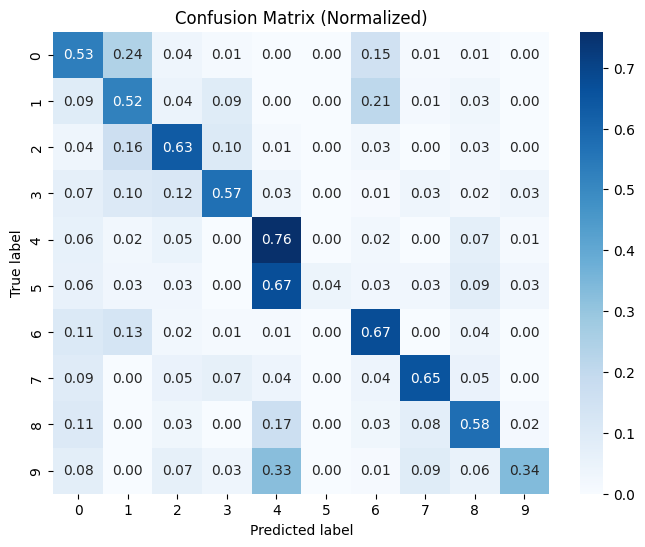

In [38]:
### START CODE HERE ###

import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# create confusion matrix 
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="0.2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix (Normalized)')
    plt.show()


# load and create confusuion matrix
def evaluate_and_plot_confusion_matrix(model, test_loader, checkpoint_path, device='cpu'):
    ## load model
    model.load_state_dict(torch.load(checkpoint_path))
    model.to(device)
    model.eval()  # Set model to evaluation mode

    # label (real and predict)
    all_preds = []
    all_labels = []

    # Disable gradient calculation
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = loss_fn(outputs, labels)  # Use raw label

            
            _, predicted = torch.max(outputs, dim=1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds, normalize='true')
    print(f"confusion matrix : {cm}")
    # แสดง Confusion Matrix
    plot_confusion_matrix(cm, class_names=[f"{i}" for i in range(10)])

# load model
checkpoint_path = r'/home/tkrittithee/mai_workspace/repo/Lab7_Data-Augmentation-CNN/check/hello'
evaluate_and_plot_confusion_matrix(model, test_loader, checkpoint_path)



### END CODE HERE ###

Visualize the feature map of ***ALL*** layers of the Convolution Feature Extractor part. Then, save it as an image

/tmp/ipykernel_346477/983561913.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


torch.Size([16, 6, 28, 28])


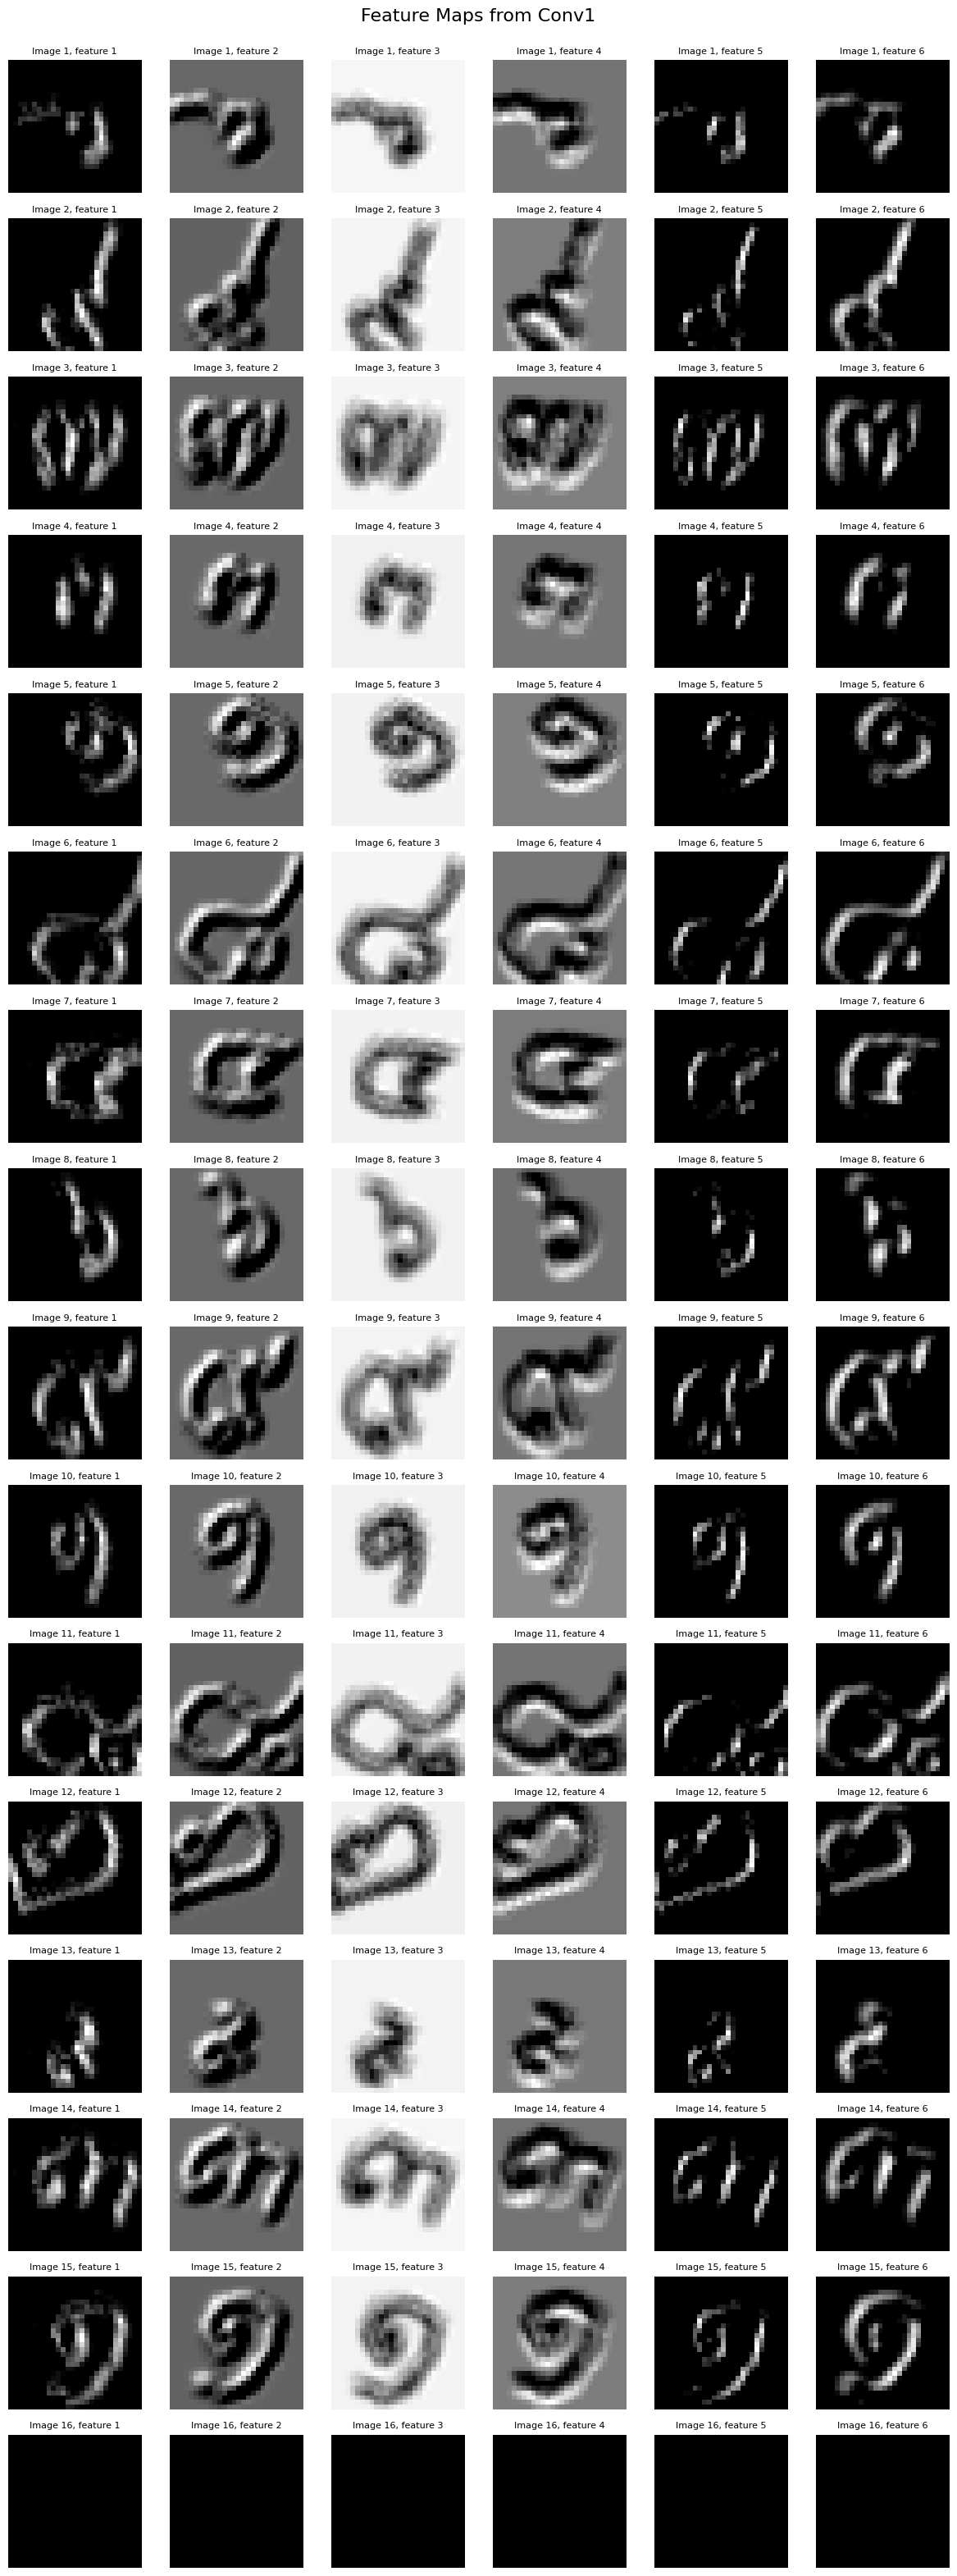

torch.Size([16, 16, 10, 10])


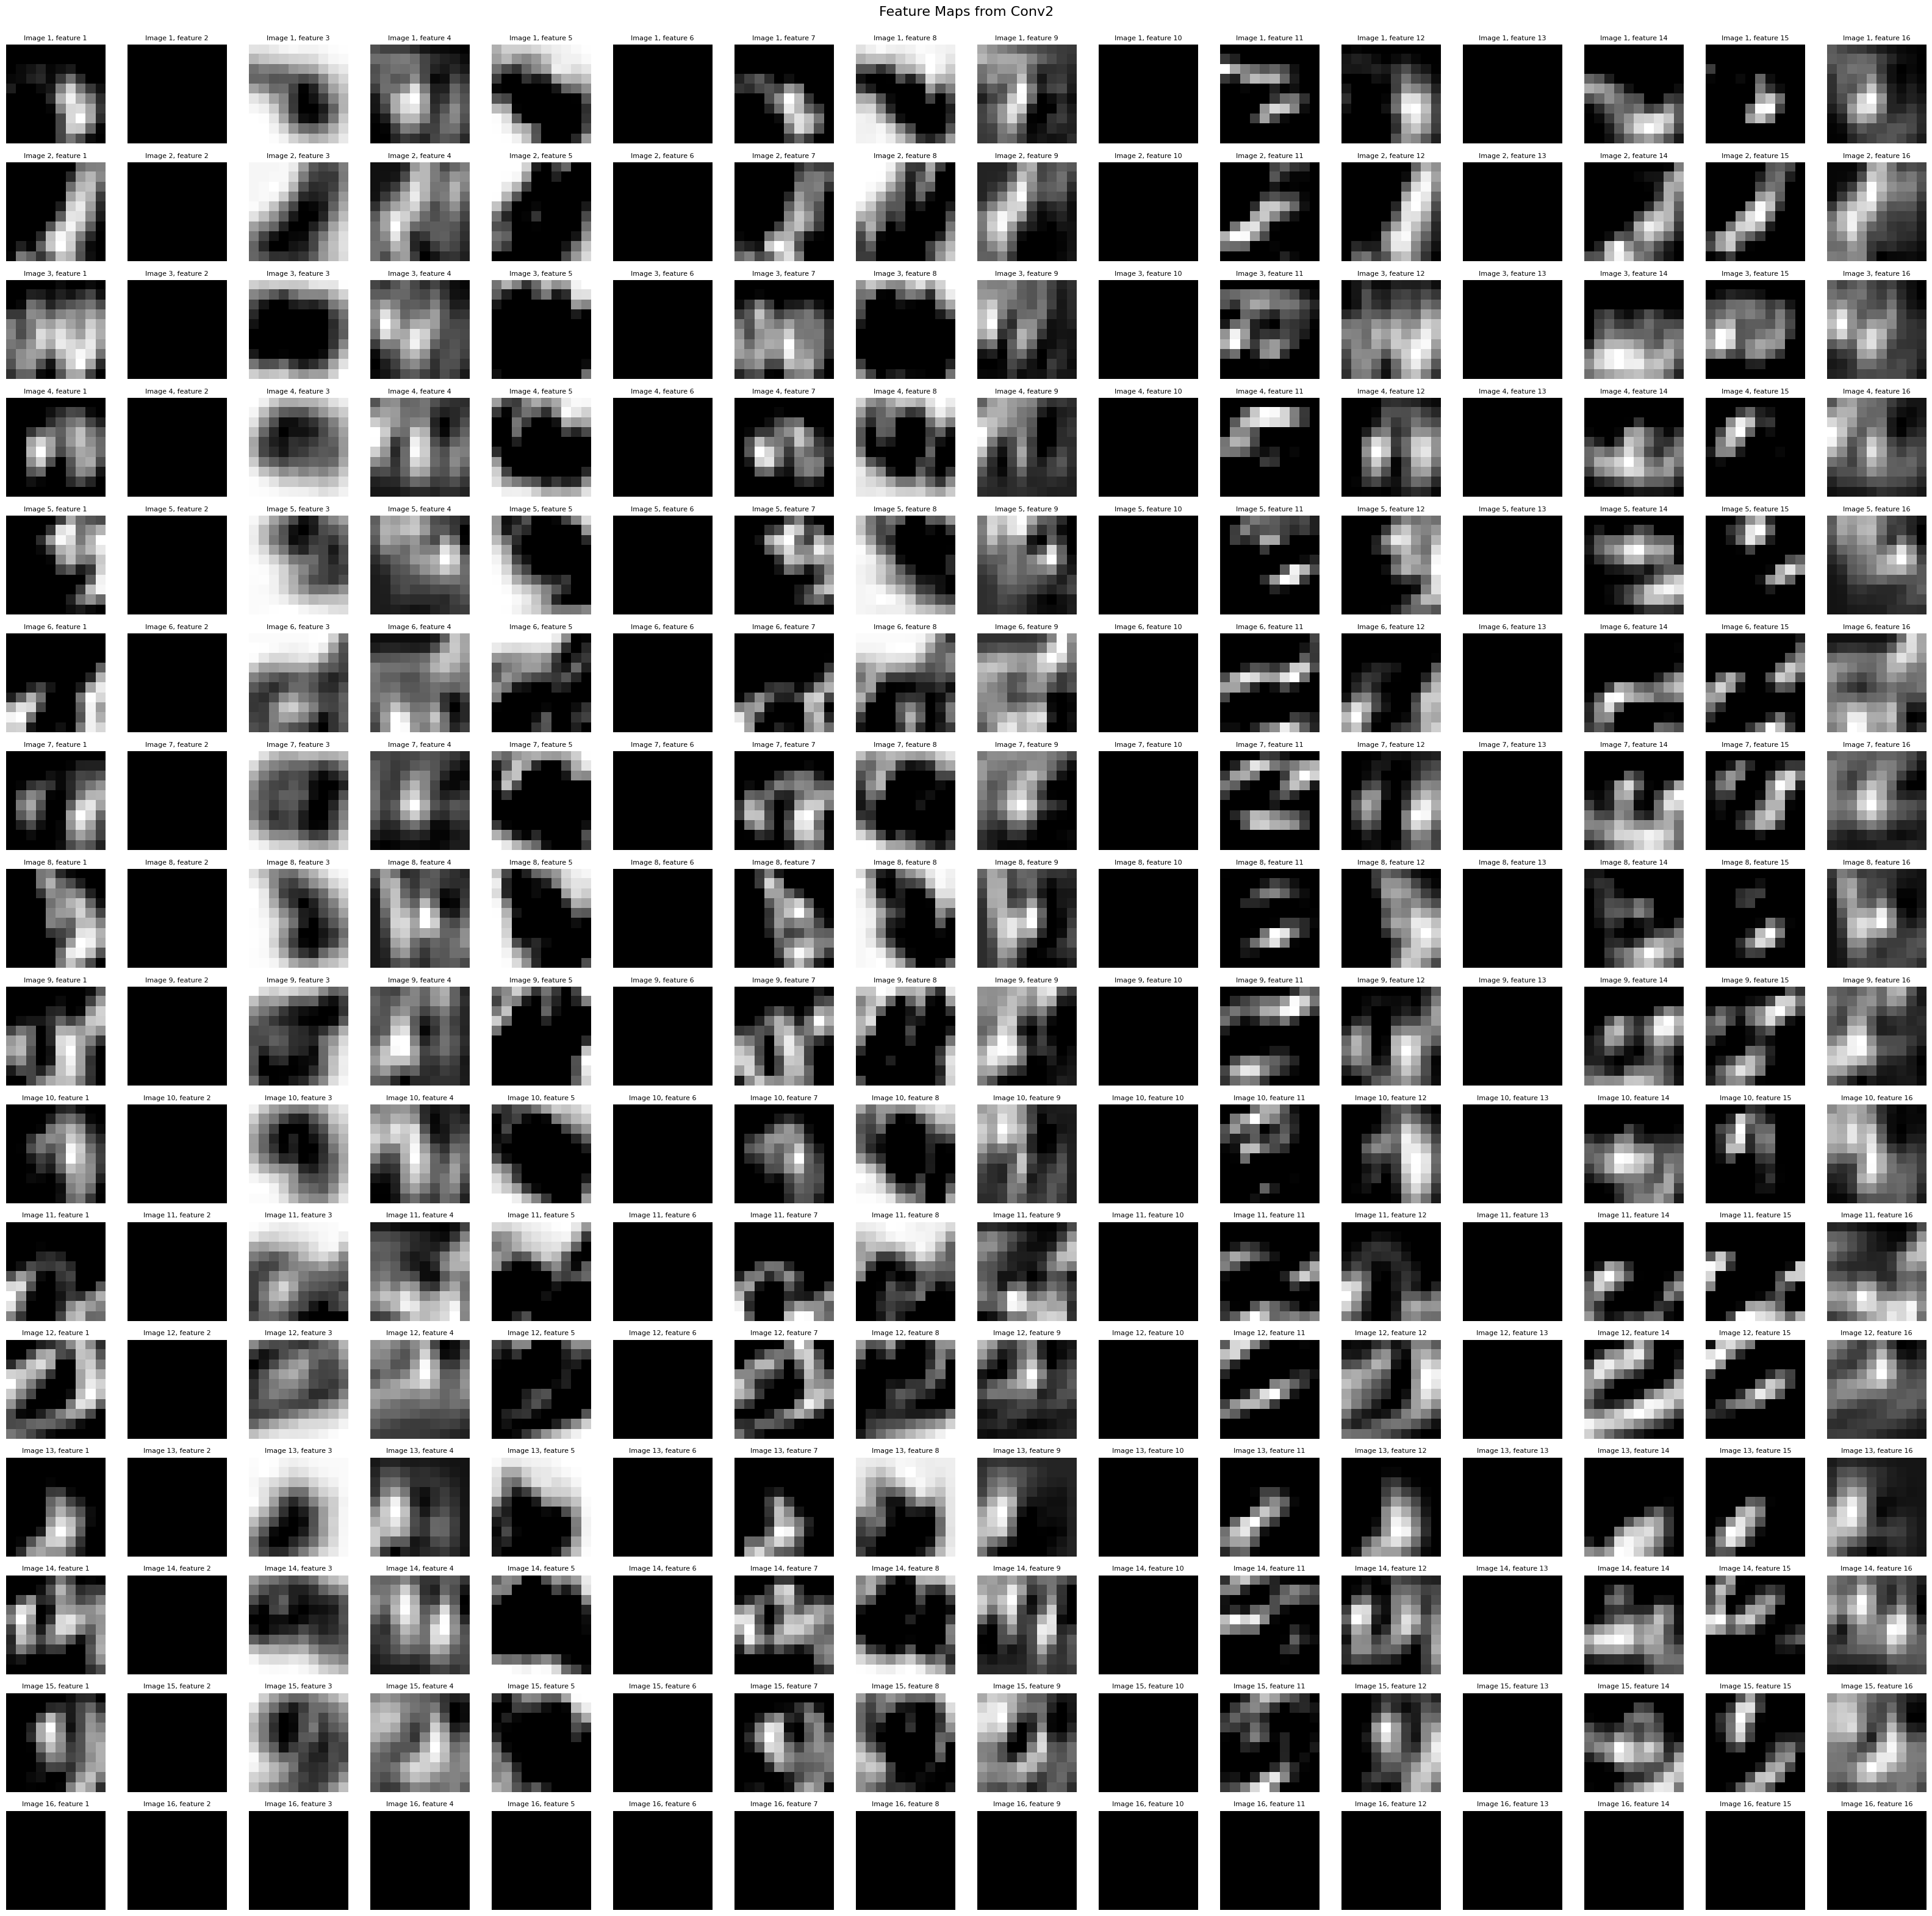

In [39]:
### START CODE HERE ###
class CustomLeNet(nn.Module):
    def __init__(self):
        super(CustomLeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)  
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  

    def forward(self, x):
        x1 = F.relu(self.conv1(x))  # feature maps ของ conv1
        x1_pooled = F.avg_pool2d(x1, kernel_size=2, stride=2)
        x2 = F.relu(self.conv2(x1_pooled))  # feature maps ของ conv2
        x2_pooled = F.avg_pool2d(x2, kernel_size=2, stride=2)
        return x1, x2  # คืนค่า feature maps ของ conv1 และ conv2

# ฟังก์ชันในการวาด feature maps
def visualize_batch_feature_maps(feature_maps, layer_name):
    print(feature_maps.shape)
    batch_size, num_feature_maps, _, _ = feature_maps.shape  # ขนาดของ batch และจำนวน feature maps

    fig, axes = plt.subplots(batch_size, num_feature_maps, figsize=(num_feature_maps * 2, batch_size * 2))

    # batch_size = 16 
    for batch_idx in range(batch_size):
        # 1 batch_size : many feature
        for fmap_idx in range(num_feature_maps):
            # Normalize feature map to range [0, 1]
            feature_map = feature_maps[batch_idx, fmap_idx].detach().numpy()
            # feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())
            
            axes[batch_idx, fmap_idx].imshow(feature_map, cmap='gray')
            axes[batch_idx, fmap_idx].axis('off')
            axes[batch_idx, fmap_idx].set_title(f'Image {batch_idx+1}, feature {fmap_idx+1}', fontsize=8)

    plt.suptitle(f'Feature Maps from {layer_name}', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.96)  # Adjust space for the title
    plt.savefig(f'{layer_name}_batch_feature_maps.png') 
    plt.show()

# create model and 
model = CustomLeNet()
checkpoint_path = r'/home/tkrittithee/mai_workspace/repo/Lab7_Data-Augmentation-CNN/check/hello'
model.load_state_dict(torch.load(checkpoint_path))
images, labels = next(iter(train_loader)) 


conv1_maps, conv2_maps = model(images)

visualize_batch_feature_maps(conv1_maps, 'Conv1')

visualize_batch_feature_maps(conv2_maps, 'Conv2')


### END CODE HERE ###

---
# Questions
1. Identify the top 3 classes with the worst F1 scores and perform an in-depth analysis of the model’s behavior on misclassified images. Analyze the feature map of an incorrectly predicted image from each class and compare it with the feature map of a correctly predicted image from the same class.
2. Does a deeper model always lead to better performance? Discuss this by considering factors such as overfitting, training time, data complexity, and model capacity. Provide examples from relevant experiments to support your argument.


1. class 5, 0, 1 แย่สุด น่าจะเพราะว่าเขียนออกมาคล้ายกัน
2. no, ดูจากที่เทรนหลายๆ epoch หากเทรนไปเรื่อยๆ บางครั้งก็จะได้่ accuracy เท่าเดิม จึงไม่มีผลต่อ performance model, 
	overfitting: หากโมเดลมีความลึกมากขึ้น โอกาสเกิด overfit ก็จะสูงขึ้น (จำมากไป)
	training time: ดูจากที่เทรนหลายๆ epoch หากเทรนไปเรื่อยๆ บางครั้งก็จะได้่ accuracy เท่าเดิม จึงไม่มีผลต่อ performance model
	datacomplexity: หากข้อมูลซับซ้อนมาก โมเดลก็ควร deeper
	Model Capacity: หากโมเดลยิ่ง deep ความใหญ่ของโมเดลก็จะมากขึ้นเพราะมีพวก weigth bias ให้เก็บมากขึ้รน